### Calculate MIG for each model iteration

In [1]:
# imports
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.compat.v1 import gfile
import pdb
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # CPU-only

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

from scipy.stats import spearmanr

In [2]:
# retrieve the representation associated with the dataset
def retrieve_representation(dataset, module_path, num_random_points, random=False):
    with hub.eval_function_for_module(module_path) as f:
        def _gaussian_encoder(x):
            """Encodes images using trained model."""
            # Push images through the TFHub module.
            output = f(dict(images=x), signature="gaussian_encoder", as_dict=True)
            # Convert to numpy arrays and return.
            return {key: np.array(values) for key, values in output.items()}
        if random:
            select_indices = random_state.choice(len(dataset.images), num_random_points, replace=False)
            images = np.expand_dims(dataset.images[select_indices], 3)
            representation_dict = _gaussian_encoder(images)
            
        else:  # retrieve representation of the entire dataset
            num_points_per_block = 10000
            num_blocks = int(np.ceil(len(dataset.images) / num_points_per_block))
            representation_list = [0] * num_blocks
            for block in range(num_blocks):
                start_idx = num_points_per_block * block
                images = np.expand_dims(dataset.images[start_idx: start_idx + num_points_per_block], 3)
                representation_list[block] = _gaussian_encoder(images)
            representation_dict = dict()
            print(representation_list[0].keys())
            for key in representation_list[0].keys():
                representation_dict[key] = np.concatenate([block[key] for block in representation_list], axis=0)
            
        representation_dict['std'] = np.exp(representation_dict['logvar'] / 2)
        representation_dict['kl'] = (
            representation_dict['mean'] ** 2
            + representation_dict['std'] ** 2
            - representation_dict['logvar'] - 1
        ) / 2
        return representation_dict

In [13]:
from disentanglement_lib.evaluation.metrics.utils import discrete_mutual_info, discrete_entropy


def histogram_discretizer(target, num_bins):
    """Discretization based on histograms."""

    discretized = np.zeros_like(target)
    for i in range(target.shape[0]):
        discretized[i, :] = np.digitize(
            target[i, :],
            np.histogram(target[i, :], num_bins)[1][:-1]
        )
    return discretized

def compute_mig(mus_train, ys_train, num_bins):
    """Computes score based on both training and testing codes and factors."""
    score_dict = {}
    discretized_mus = histogram_discretizer(mus_train, num_bins)
    m = discrete_mutual_info(discretized_mus, ys_train)
    assert m.shape[0] == mus_train.shape[0]
    assert m.shape[1] == ys_train.shape[0]
    # m is [num_latents, num_factors]
    entropy = discrete_entropy(ys_train)
    sorted_m = np.sort(m, axis=0)[::-1]
    if sorted_m.shape[0] == 1:
        per_fov_mig = np.divide(np.zeros(sorted_m[0, :].shape), entropy[:])
    else:
        per_fov_mig = np.divide(sorted_m[0, :] - sorted_m[1, :], entropy[:])
    
    score_dict["per_fov_mig"] = per_fov_mig
    score_dict["discrete_mig"] = np.mean(per_fov_mig)
    score_dict["mi_matrix"] = m
    score_dict["entropy"] = entropy
    return score_dict

In [4]:
# get the original dsprites dataset
from disentanglement_lib.data.ground_truth import named_data
# dsprites = named_data.get_named_ground_truth_data('dsprites_full', -1)
# smallnorb = named_data.get_named_ground_truth_data('smallnorb', -1)
mpi3d = named_data.get_named_ground_truth_data('mpi3d_toy', -1)
# cars = named_data.get_named_ground_truth_data('cars3d', -1)
# shapes3d = named_data.get_named_ground_truth_data('shapes3d', -1)

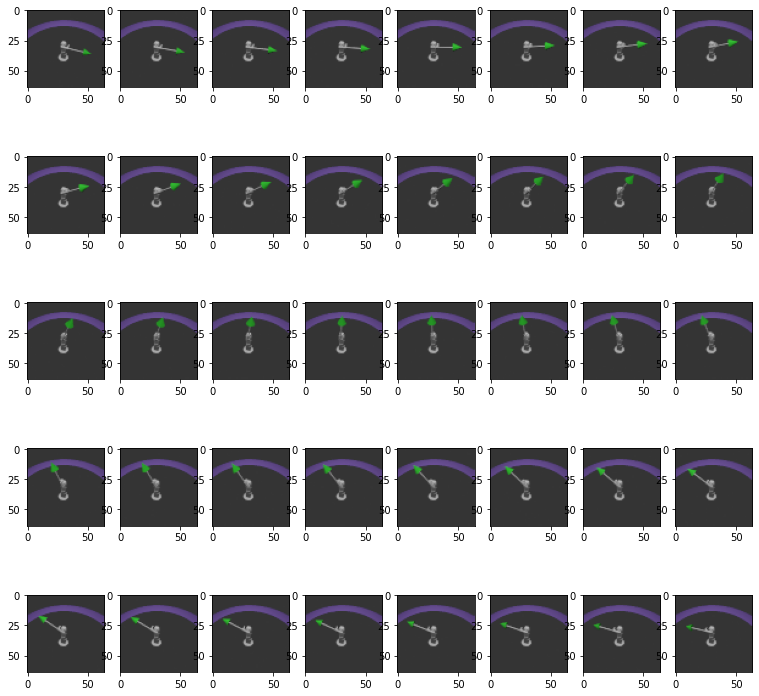

In [86]:
dataset = mpi3d
interest_index = 5
num_values = dataset.factors_num_values[interest_index]
factors = np.zeros((num_values, dataset.num_factors))
fig, axs = plt.subplots(5, 8, figsize=(13, 13))

for i in range(num_values):
    factors[i, 1] = 0
    factors[i, interest_index] = i
indices = np.matmul(factors, dataset.factor_bases).astype(int)
    
for i in range(num_values):
    ax = axs[i // 8, i % 8]
    ax.imshow(dataset.images[indices[i]])


In [103]:
# for a model, retrieve dropout mean and uncertainty 
model_artifact_dir = "/home/mwu34/disentanglement_lib/output_active_learning_study_v10/10/model/artifacts/"
labelled_indices = []
dropout_mean = []
num_iterations = 9
num_latent = 10
dataset = dsprites


for iteration in range(10):
    file_path = os.path.join(model_artifact_dir, f"labelled_indices_iter_{iteration}.npy")
    indices = np.load(file_path)
    labelled_indices.extend(list(indices))
    if iteration > 0:
        mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_{iteration}.npy")
        mus = np.load(mean_file_path)
        dropout_mean.append(mus)
        
labelled_factors = index_to_factors(labelled_indices, dataset.factor_bases, save=False)

no save_path specified, not saving informative points


In [14]:
def calculate_disentanglement_metric_for_all_iterations(
    dataset,
    num_training_points,
    num_bins,
    num_iterations,
    model_artifact_dir,
    save_results=False,
    apply_sigmoid=False,
):
    mig = np.zeros((1, num_iterations))
    per_fov_mig = np.zeros((dataset.num_factors, num_iterations))
    mi_matrix = np.zeros((10, dataset.num_factors, num_iterations))
    entropy = np.zeros((dataset.num_factors, num_iterations))
    # use same set of indices for all mig calculation
    random_indices = np.random.choice(len(dataset.images), num_training_points, replace=False)
    factors_train = dataset.index_to_factors(random_indices).T

    for iteration in range(1, num_iterations + 1):
        mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_{iteration}.npy")
        mus = np.load(mean_file_path)
        if apply_sigmoid:
            mus = 1 / (1 + np.exp(-mus))
        mus_train = mus[random_indices, :].T
        mig_results = compute_mig(mus_train, factors_train, num_bins)
        mig[0, iteration - 1] = mig_results['discrete_mig']
        per_fov_mig[:, iteration - 1] = mig_results['per_fov_mig']
        mi_matrix[:, :, iteration - 1] = mig_results['mi_matrix']
        entropy[:, iteration - 1] = mig_results['entropy']
        
    print(f"mig each iter is: \n{mig}")
    print(f"mig per fov is \n{per_fov_mig}")
    if save_results:
        results_path = os.path.join(model_artifact_dir, "mig_results.npy")
        np.save(results_path, mig)
    return mig, per_fov_mig, mi_matrix, entropy
    

In [18]:
mig15 = overall_mig

In [38]:
[i - j for i, j in zip(mig12, mig13)]

[0.012344846302935697,
 -0.021803150950333028,
 -0.01177057530137443,
 -0.01187668187511548,
 -0.03319676030356933,
 -0.0018308622312350198,
 0.0013424853105283852,
 -0.011060451932817517,
 0.0024220549851431405,
 -0.01181657378354567,
 -0.014507239426468976,
 -0.008880394849300921,
 -0.01353268239712141,
 0.0010279927259946309,
 -0.011864013187735]

In [9]:
mig

array([[0.061, 0.077, 0.076, 0.075, 0.07 , 0.065, 0.064, 0.067, 0.064,
        0.064]])

In [18]:
num_training_points = 10000
num_bins = 20
num_iterations = 1
exp_idx = 16
dataset = mpi3d
overall_mig = []

model_folder_path = "/home/mwu34/disentanglement_lib/"
# model_folder_path = "/mnt/data1/active_learning_representations"

for model_idx in range(15, 30):
    model_artifact_dir = os.path.join(
        model_folder_path,
        f"output_active_learning_study_v{exp_idx}/{model_idx}/model/artifacts/"
    )
    print(f'calculating mig at model_idx: {model_idx}')
    mig, per_fov_mig, mi_matrix, entropy = calculate_disentanglement_metric_for_all_iterations(
        dataset,
        num_training_points,
        num_bins,
        num_iterations,
        model_artifact_dir,
        save_results=False,
        apply_sigmoid=False
    )
    overall_mig.append(mig[0, -1])


calculating mig at model_idx: 15
mig each iter is: 
[[0.212]]
mig per fov is 
[[0.231]
 [0.002]
 [0.015]
 [0.265]
 [0.502]
 [0.159]
 [0.312]]
calculating mig at model_idx: 16
mig each iter is: 
[[0.371]]
mig per fov is 
[[0.436]
 [0.018]
 [0.059]
 [0.922]
 [0.689]
 [0.149]
 [0.323]]
calculating mig at model_idx: 17
mig each iter is: 
[[0.341]]
mig per fov is 
[[0.4  ]
 [0.011]
 [0.053]
 [0.751]
 [0.706]
 [0.15 ]
 [0.32 ]]
calculating mig at model_idx: 18
mig each iter is: 
[[0.351]]
mig per fov is 
[[0.413]
 [0.002]
 [0.085]
 [0.823]
 [0.704]
 [0.129]
 [0.302]]
calculating mig at model_idx: 19
mig each iter is: 
[[0.302]]
mig per fov is 
[[0.393]
 [0.002]
 [0.061]
 [0.526]
 [0.719]
 [0.126]
 [0.286]]
calculating mig at model_idx: 20
mig each iter is: 
[[0.246]]
mig per fov is 
[[0.209]
 [0.001]
 [0.002]
 [0.472]
 [0.477]
 [0.219]
 [0.342]]
calculating mig at model_idx: 21
mig each iter is: 
[[0.376]]
mig per fov is 
[[0.418]
 [0.017]
 [0.049]
 [0.944]
 [0.711]
 [0.161]
 [0.336]]
calcul

In [16]:
entropy

array([[1.386],
       [1.386],
       [0.693],
       [1.099],
       [1.099],
       [3.686],
       [3.686]])

In [9]:
for i in range(1):
    print(f"iter {i}\n{mi_matrix[:, :, i]}")

iter 0
[[0.587 0.013 0.007 0.005 0.003 0.061 0.048]
 [0.018 0.032 0.002 0.012 0.008 0.066 0.055]
 [0.031 0.024 0.039 0.004 0.006 0.062 0.043]
 [0.03  0.008 0.006 0.972 0.026 0.072 0.073]
 [0.025 0.01  0.004 0.026 0.872 0.053 0.068]
 [0.03  0.005 0.002 0.011 0.002 0.606 0.057]
 [0.006 0.003 0.001 0.028 0.004 0.052 1.191]
 [0.019 0.005 0.001 0.054 0.024 0.054 0.067]
 [0.02  0.004 0.001 0.072 0.016 0.084 0.14 ]
 [0.011 0.005 0.001 0.197 0.014 0.07  0.117]]


In [11]:
# correlation between fovs and latent units
dataset = mpi3d
random_indices = np.random.choice(len(dataset.images), num_training_points, replace=False)


for model_idx in range(15, 20):
    model_artifact_dir = os.path.join(
        "/home/mwu34/disentanglement_lib/",
        f"output_active_learning_study_v{exp_idx}/{model_idx}/model/artifacts/"
    )
    factors_train = dataset.index_to_factors(random_indices).T
    mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_1.npy")
    mus = np.load(mean_file_path)
    mus_train = mus[random_indices].T
    correlation = np.corrcoef(np.concatenate((factors_train, mus_train), axis=0))
    x_correlation = correlation[:dataset.num_factors, dataset.num_factors:]
    np.fill_diagonal(x_correlation, 0)
    print(f"at model {model_idx}")
    print(x_correlation)
    print(np.sum(np.abs(x_correlation)))
    
    

at model 15
[[ 0.     0.072  0.089 -0.038 -0.033  0.035  0.002  0.052  0.239  0.013]
 [-0.033  0.    -0.081  0.014  0.006 -0.019  0.011 -0.002 -0.036  0.03 ]
 [-0.152  0.009  0.     0.032  0.02  -0.011 -0.007 -0.038  0.092 -0.033]
 [-0.     0.022 -0.005  0.     0.106 -0.028  0.007 -0.532  0.192  0.196]
 [-0.007 -0.001  0.018  0.16   0.    -0.015  0.01   0.137 -0.076  0.182]
 [ 0.058 -0.03  -0.088 -0.006  0.006  0.     0.011 -0.23  -0.132  0.175]
 [ 0.012  0.056 -0.01  -0.01  -0.051 -0.012  0.     0.273 -0.149 -0.055]]
4.256392068250378
at model 16
[[ 0.     0.011 -0.009 -0.01  -0.034  0.036 -0.018 -0.078  0.051 -0.   ]
 [-0.038  0.    -0.011  0.009  0.016 -0.011  0.016 -0.02  -0.006 -0.015]
 [-0.124  0.065  0.     0.017  0.026 -0.033 -0.011  0.051 -0.053 -0.011]
 [ 0.021  0.034 -0.036  0.     0.021 -0.001  0.017 -0.045 -0.192 -0.099]
 [ 0.012 -0.016  0.119  0.045  0.    -0.002  0.007  0.099 -0.036  0.099]
 [ 0.033 -0.075 -0.062 -0.01  -0.031  0.    -0.009  0.002 -0.016 -0.049]
 [-0.013

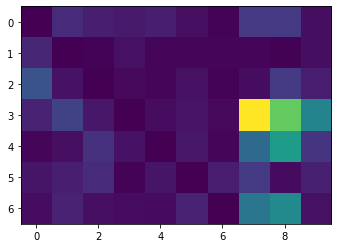

In [12]:
plt.imshow(np.abs(x_correlation))

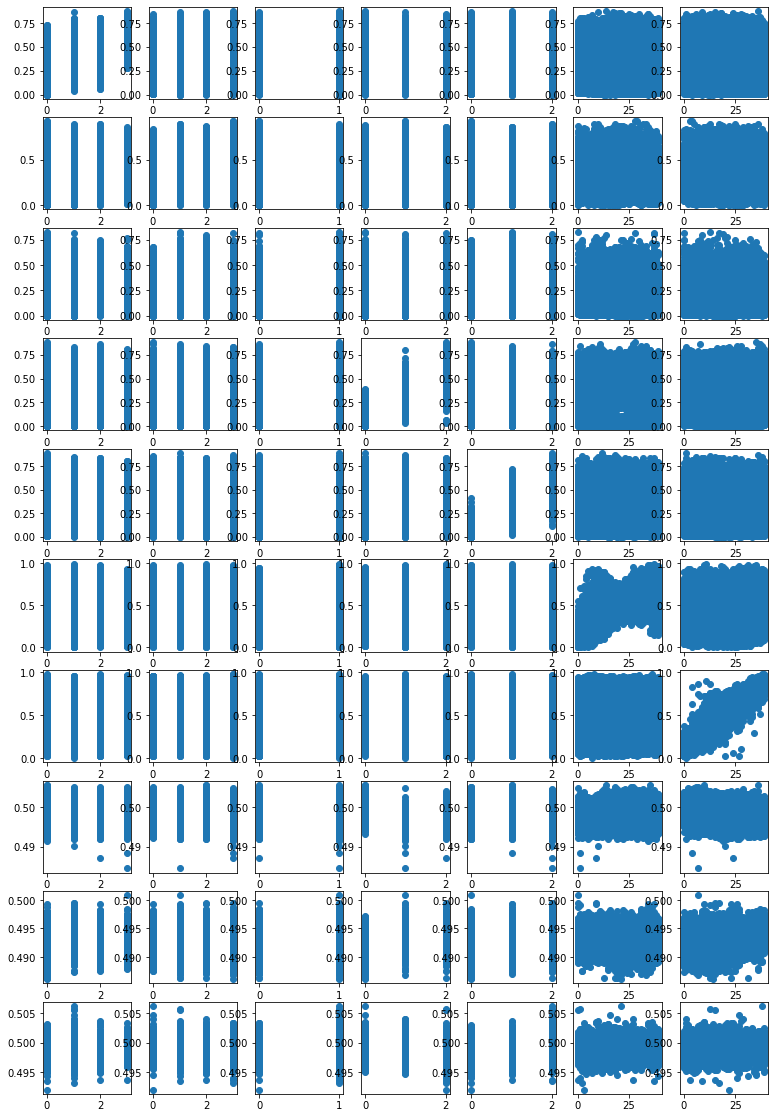

In [17]:
# visualize correlation between fovs and latent units
num_latents = mus_train.shape[0]
num_fovs = factors_train.shape[0]

fig, axs = plt.subplots(num_latents, num_fovs, figsize=(13, 20))
for latent in range(num_latents):
    for fov in range(num_fovs):
        ax = axs[latent][fov]
        ax.scatter(factors_train[fov, :], 1/(1 + np.exp(-mus_train[latent, :])))
